# Phase 2: Data Understanding
## AWS Cluster Anomaly Detection Project

---

### CRISP-DM Phase 2: Data Understanding

**Objective:** Understand the data structure, quality, and characteristics through comprehensive Exploratory Data Analysis (EDA)

---

## 📋 Table of Contents
1. [Data Collection](#data-collection)
2. [Initial Data Exploration](#initial-exploration)
3. [Data Quality Assessment](#data-quality)
4. [Exploratory Data Analysis (EDA)](#eda)
5. [Statistical Analysis](#statistical-analysis)
6. [Temporal Patterns](#temporal-patterns)
7. [Correlation Analysis](#correlation-analysis)
8. [Data Understanding Summary](#summary)

In [19]:
# Import Required Libraries
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical Analysis
from scipy import stats
from scipy.stats import shapiro, normaltest, anderson

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Data Collection 📊

### Data Sources
- **Source:** AWS Prometheus metrics exported to JSON
- **Metrics:**
  1. `cluster_cpu_request_ratio` - CPU resource requests vs available
  2. `cluster_mem_request_ratio` - Memory resource requests vs available
  3. `cluster_pod_ratio` - Pod count vs capacity
- **Frequency:** 5-minute intervals
- **Format:** JSON time-series data

In [20]:
# Load Data from JSON files
def load_prometheus_data(file_path):
    """
    Load Prometheus metrics from JSON file
    
    Parameters:
    -----------
    file_path : str
        Path to JSON file
    
    Returns:
    --------
    pd.DataFrame : Loaded data
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Extract time-series values
    values = data['data']['result'][0]['values']
    
    # Create DataFrame
    df = pd.DataFrame(values, columns=['timestamp', 'value'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['value'] = df['value'].astype(float)
    
    return df

# Load all metrics
print("Loading data files...")
data_path = '../data/'

# Load CPU data
df_cpu = load_prometheus_data('../../cluster_cpu_request_ratio.json')
df_cpu.rename(columns={'value': 'cluster_cpu_request_ratio'}, inplace=True)
print(f"✅ CPU data loaded: {len(df_cpu)} records")

# Load Memory data
df_mem = load_prometheus_data('../../cluster_mem_request_ratio.json')
df_mem.rename(columns={'value': 'cluster_mem_request_ratio'}, inplace=True)
print(f"✅ Memory data loaded: {len(df_mem)} records")

# Load Pod data
df_pod = load_prometheus_data('../../cluster_pod_ratio.json')
df_pod.rename(columns={'value': 'cluster_pod_ratio'}, inplace=True)
print(f"✅ Pod data loaded: {len(df_pod)} records")

# Merge all metrics
df = df_cpu[['timestamp', 'cluster_cpu_request_ratio']].copy()
df['cluster_mem_request_ratio'] = df_mem['cluster_mem_request_ratio'].values
df['cluster_pod_ratio'] = df_pod['cluster_pod_ratio'].values

print(f"\n✅ Data merged successfully!")
print(f"Total records: {len(df)}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")

Loading data files...
✅ CPU data loaded: 230 records
✅ Memory data loaded: 230 records
✅ Pod data loaded: 230 records

✅ Data merged successfully!
Total records: 230
Date range: 2025-10-27 12:30:00 to 2025-11-02 17:15:00
Duration: 6 days


## 2. Initial Data Exploration 🔍

In [21]:
# Display first few records
print("=" * 80)
print("FIRST 10 RECORDS")
print("=" * 80)
display(df.head(10))

# Display last few records
print("\n" + "=" * 80)
print("LAST 10 RECORDS")
print("=" * 80)
display(df.tail(10))

FIRST 10 RECORDS


,timestamp,cluster_cpu_request_ratio,cluster_mem_request_ratio,cluster_pod_ratio
0,2025-10-27 12:30:00,0.615371,0.646098,0.193333
1,2025-10-27 12:35:00,0.615371,0.646098,0.193333
2,2025-10-27 12:40:00,0.615371,0.646098,0.193333
3,2025-10-27 12:45:00,0.615371,0.646098,0.193333
4,2025-10-27 12:50:00,0.615371,0.646098,0.193333
5,2025-10-27 12:55:00,0.615371,0.646098,0.193333
6,2025-10-27 13:00:00,0.615371,0.646098,0.193333
7,2025-10-27 13:05:00,0.615371,0.646098,0.193333
8,2025-10-27 13:10:00,0.615371,0.646098,0.193333
9,2025-10-27 13:15:00,0.615371,0.646098,0.193333



LAST 10 RECORDS


,timestamp,cluster_cpu_request_ratio,cluster_mem_request_ratio,cluster_pod_ratio
220,2025-11-02 16:30:00,0.615371,0.646097,0.192
221,2025-11-02 16:35:00,0.615371,0.646097,0.192
222,2025-11-02 16:40:00,0.615371,0.646097,0.192
223,2025-11-02 16:45:00,0.615371,0.646097,0.192
224,2025-11-02 16:50:00,0.615371,0.646097,0.192
225,2025-11-02 16:55:00,0.615371,0.646097,0.192
226,2025-11-02 17:00:00,0.615371,0.646097,0.192
227,2025-11-02 17:05:00,0.615371,0.646097,0.192
228,2025-11-02 17:10:00,0.615371,0.646097,0.192
229,2025-11-02 17:15:00,0.615371,0.646097,0.192


In [22]:
# Dataset Information
print("=" * 80)
print("DATASET INFORMATION")
print("=" * 80)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nColumn Data Types:")
print(df.dtypes)
print("\n" + "=" * 80)
df.info()

DATASET INFORMATION
Shape: 230 rows × 4 columns

Memory Usage: 0.01 MB

Column Data Types:
timestamp                    datetime64[ns]
cluster_cpu_request_ratio           float64
cluster_mem_request_ratio           float64
cluster_pod_ratio                   float64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   timestamp                  230 non-null    datetime64[ns]
 1   cluster_cpu_request_ratio  230 non-null    float64       
 2   cluster_mem_request_ratio  230 non-null    float64       
 3   cluster_pod_ratio          230 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 7.3 KB


## 3. Data Quality Assessment ✅

In [5]:
# Missing Values Analysis
print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2),
    'Data Type': df.dtypes
})

display(missing_data)

if missing_data['Missing Count'].sum() == 0:
    print("\n✅ No missing values found!")
else:
    print(f"\n⚠️ Total missing values: {missing_data['Missing Count'].sum()}")

MISSING VALUES ANALYSIS


,Column,Missing Count,Missing %,Data Type
timestamp,timestamp,0,0.0,datetime64[ns]
cluster_cpu_request_ratio,cluster_cpu_request_ratio,0,0.0,float64
cluster_mem_request_ratio,cluster_mem_request_ratio,0,0.0,float64
cluster_pod_ratio,cluster_pod_ratio,0,0.0,float64



✅ No missing values found!


In [6]:
# Duplicate Records Check
print("=" * 80)
print("DUPLICATE RECORDS CHECK")
print("=" * 80)

duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check for duplicate timestamps
duplicate_timestamps = df['timestamp'].duplicated().sum()
print(f"Duplicate timestamps: {duplicate_timestamps}")

if duplicates == 0 and duplicate_timestamps == 0:
    print("\n✅ No duplicates found!")
else:
    print("\n⚠️ Duplicates detected - will need cleaning")

DUPLICATE RECORDS CHECK
Duplicate rows: 0
Duplicate timestamps: 0

✅ No duplicates found!


In [7]:
# Data Consistency Checks
print("=" * 80)
print("DATA CONSISTENCY CHECKS")
print("=" * 80)

# Check for values outside expected range [0, 1]
metrics = ['cluster_cpu_request_ratio', 'cluster_mem_request_ratio', 'cluster_pod_ratio']

for metric in metrics:
    out_of_range = ((df[metric] < 0) | (df[metric] > 1)).sum()
    print(f"{metric}:")
    print(f"  - Values < 0: {(df[metric] < 0).sum()}")
    print(f"  - Values > 1: {(df[metric] > 1).sum()}")
    print(f"  - Out of range [0,1]: {out_of_range}")
    print()

# Check for NaN and infinity
print("Infinite values:")
for metric in metrics:
    inf_count = np.isinf(df[metric]).sum()
    print(f"  {metric}: {inf_count}")

print("\n✅ Data consistency check complete!")

DATA CONSISTENCY CHECKS
cluster_cpu_request_ratio:
  - Values < 0: 0
  - Values > 1: 0
  - Out of range [0,1]: 0

cluster_mem_request_ratio:
  - Values < 0: 0
  - Values > 1: 0
  - Out of range [0,1]: 0

cluster_pod_ratio:
  - Values < 0: 0
  - Values > 1: 0
  - Out of range [0,1]: 0

Infinite values:
  cluster_cpu_request_ratio: 0
  cluster_mem_request_ratio: 0
  cluster_pod_ratio: 0

✅ Data consistency check complete!


## 4. Exploratory Data Analysis (EDA) 📊

### 4.1 Descriptive Statistics

In [8]:
# Comprehensive Descriptive Statistics
print("=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)

desc_stats = df[metrics].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
display(desc_stats)

# Additional statistics
print("\nAdditional Statistics:")
print("=" * 80)
additional_stats = pd.DataFrame({
    'Metric': metrics,
    'Range': [df[m].max() - df[m].min() for m in metrics],
    'IQR': [df[m].quantile(0.75) - df[m].quantile(0.25) for m in metrics],
    'Coefficient of Variation': [df[m].std() / df[m].mean() * 100 for m in metrics],
    'Skewness': [df[m].skew() for m in metrics],
    'Kurtosis': [df[m].kurtosis() for m in metrics]
})
display(additional_stats.round(4))

DESCRIPTIVE STATISTICS


,cluster_cpu_request_ratio,cluster_mem_request_ratio,cluster_pod_ratio
count,230.000000,230.000000,230.000000
mean,0.617308,0.646089,0.192771
std,0.022251,0.034811,0.006800
min,0.529016,0.333562,0.180000
1%,0.615371,0.642205,0.190667
5%,0.615371,0.646097,0.190667
25%,0.615371,0.646098,0.190667
50%,0.615371,0.646098,0.192000
75%,0.615371,0.646098,0.193333
95%,0.615371,0.646098,0.193333



Additional Statistics:


,Metric,Range,IQR,Coefficient of Variation,Skewness,Kurtosis
0,cluster_cpu_request_ratio,0.3080,0.0000,3.6045,8.5029,84.5560
1,cluster_mem_request_ratio,0.5741,0.0000,5.3879,-0.3782,60.3012
2,cluster_pod_ratio,0.0740,0.0027,3.5273,7.8700,66.4409


### 4.2 Distribution Visualizations

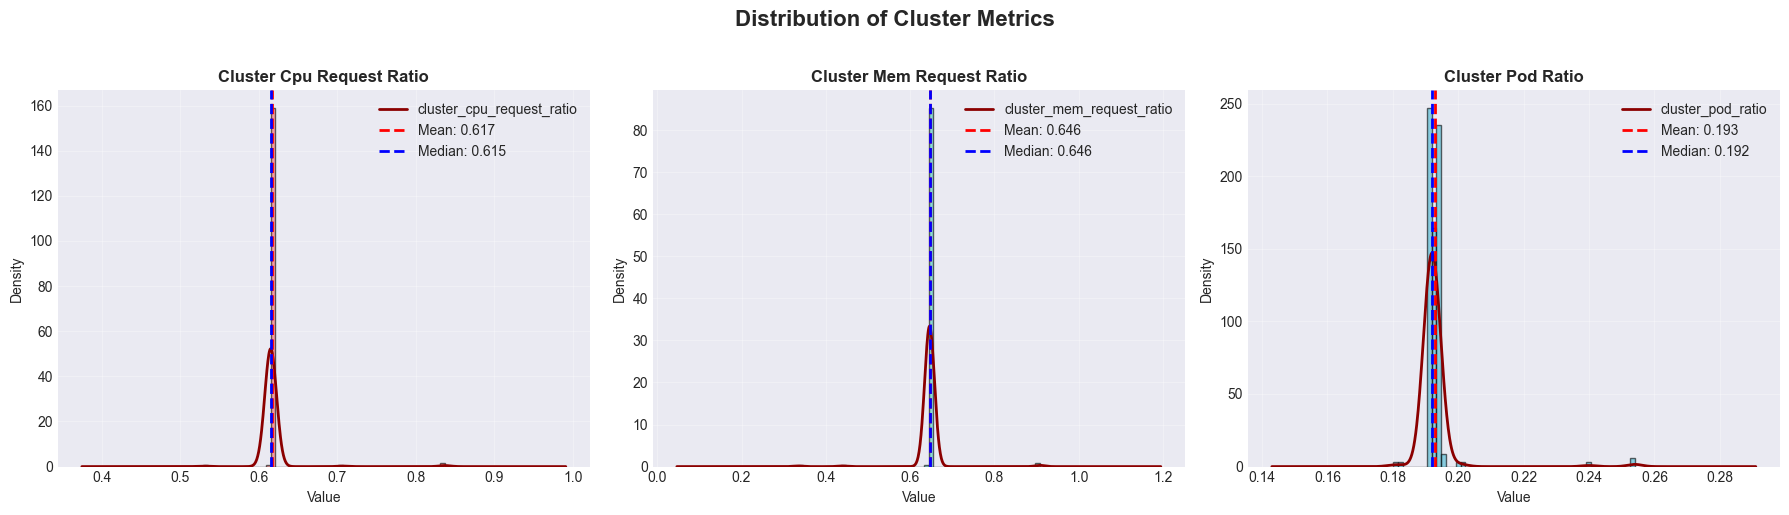

✅ Distribution plots saved to reports/01_distribution_plots.png


In [9]:
# Distribution Plots - Histograms with KDE
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Cluster Metrics', fontsize=16, fontweight='bold', y=1.02)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Histogram with KDE
    ax.hist(df[metric], bins=50, alpha=0.6, color=colors[idx], edgecolor='black', density=True)
    
    # KDE overlay
    df[metric].plot(kind='density', ax=ax, color='darkred', linewidth=2)
    
    # Add mean and median lines
    mean_val = df[metric].mean()
    median_val = df[metric].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
    ax.axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
    
    ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/01_distribution_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Distribution plots saved to reports/01_distribution_plots.png")

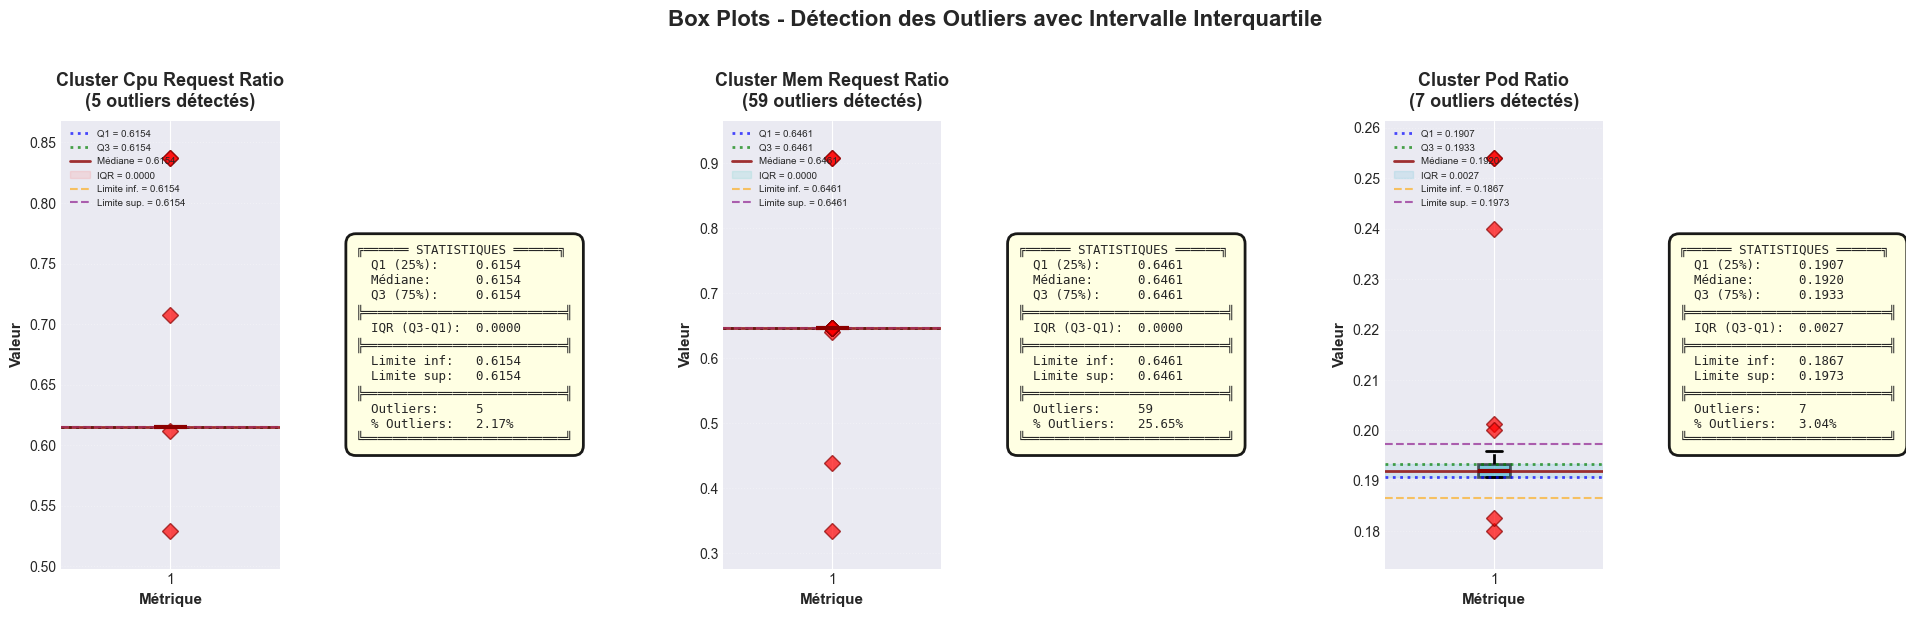

✅ Box plots améliorés sauvegardés dans reports/02_boxplots_outliers.png

📊 Résumé des outliers détectés:
  • cluster_cpu_request_ratio: 5 outliers (2.17%) - IQR = 0.0000
  • cluster_mem_request_ratio: 59 outliers (25.65%) - IQR = 0.0000
  • cluster_pod_ratio: 7 outliers (3.04%) - IQR = 0.0027


In [23]:
# Box Plots - Outlier Detection (Version Améliorée)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Box Plots - Détection des Outliers avec Intervalle Interquartile', 
             fontsize=16, fontweight='bold', y=1.02)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Calculer les statistiques
    q1 = df[metric].quantile(0.25)
    q3 = df[metric].quantile(0.75)
    iqr = q3 - q1
    median = df[metric].median()
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Identifier les outliers
    outliers_mask = (df[metric] < lower_bound) | (df[metric] > upper_bound)
    outliers_count = outliers_mask.sum()
    outliers_values = df[metric][outliers_mask]
    
    # Créer le boxplot
    bp = ax.boxplot(df[metric], vert=True, patch_artist=True,
                    boxprops=dict(facecolor=colors[idx], alpha=0.6, edgecolor='black', linewidth=2),
                    medianprops=dict(color='darkred', linewidth=3),
                    whiskerprops=dict(color='black', linewidth=2, linestyle='--'),
                    capprops=dict(color='black', linewidth=2),
                    flierprops=dict(marker='D', markerfacecolor='red', markersize=8, 
                                   markeredgecolor='darkred', alpha=0.7, linewidth=1.5))
    
    # Ajouter des lignes horizontales pour Q1, Q3 et Médiane
    ax.axhline(y=q1, color='blue', linestyle=':', linewidth=2, alpha=0.7, label=f'Q1 = {q1:.4f}')
    ax.axhline(y=q3, color='green', linestyle=':', linewidth=2, alpha=0.7, label=f'Q3 = {q3:.4f}')
    ax.axhline(y=median, color='darkred', linestyle='-', linewidth=2, alpha=0.8, label=f'Médiane = {median:.4f}')
    
    # Ajouter une zone ombrée pour l'IQR
    ax.axhspan(q1, q3, alpha=0.15, color=colors[idx], label=f'IQR = {iqr:.4f}')
    
    # Ajouter des lignes pour les limites des outliers
    ax.axhline(y=lower_bound, color='orange', linestyle='--', linewidth=1.5, alpha=0.6, 
               label=f'Limite inf. = {lower_bound:.4f}')
    ax.axhline(y=upper_bound, color='purple', linestyle='--', linewidth=1.5, alpha=0.6, 
               label=f'Limite sup. = {upper_bound:.4f}')
    
    # Statistiques détaillées dans une boîte
    stats_text = (
        f'╔══════ STATISTIQUES ══════╗\n'
        f'  Q1 (25%):     {q1:.4f}\n'
        f'  Médiane:      {median:.4f}\n'
        f'  Q3 (75%):     {q3:.4f}\n'
        f'╠═══════════════════════════╣\n'
        f'  IQR (Q3-Q1):  {iqr:.4f}\n'
        f'╠═══════════════════════════╣\n'
        f'  Limite inf:   {lower_bound:.4f}\n'
        f'  Limite sup:   {upper_bound:.4f}\n'
        f'╠═══════════════════════════╣\n'
        f'  Outliers:     {outliers_count}\n'
        f'  % Outliers:   {outliers_count/len(df)*100:.2f}%\n'
        f'╚═══════════════════════════╝'
    )
    
    ax.text(1.35, 0.5, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='center', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', 
                     edgecolor='black', linewidth=2, alpha=0.9))
    
    # Configuration de l'axe
    ax.set_title(f'{metric.replace("_", " ").title()}\n({outliers_count} outliers détectés)', 
                fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel('Valeur', fontsize=11, fontweight='bold')
    ax.set_xlabel('Métrique', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle=':', linewidth=0.8)
    
    # Légende compacte
    ax.legend(loc='upper left', fontsize=7, framealpha=0.9, 
             bbox_to_anchor=(0, 1), ncol=1)
    
    # Limites de l'axe y pour mieux voir tous les éléments
    data_min = df[metric].min()
    data_max = df[metric].max()
    y_margin = (data_max - data_min) * 0.1
    ax.set_ylim([data_min - y_margin, data_max + y_margin])

plt.tight_layout()
plt.savefig('../reports/02_boxplots_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Box plots améliorés sauvegardés dans reports/02_boxplots_outliers.png")
print("\n📊 Résumé des outliers détectés:")
for metric in metrics:
    q1 = df[metric].quantile(0.25)
    q3 = df[metric].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((df[metric] < lower_bound) | (df[metric] > upper_bound)).sum()
    print(f"  • {metric}: {outliers} outliers ({outliers/len(df)*100:.2f}%) - IQR = {iqr:.4f}")

### 4.3 Time Series Visualization

In [11]:
# Interactive Time Series Plot with Plotly
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('CPU Request Ratio', 'Memory Request Ratio', 'Pod Ratio'),
    vertical_spacing=0.08,
    shared_xaxes=True
)

colors_plotly = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (metric, color) in enumerate(zip(metrics, colors_plotly), 1):
    fig.add_trace(
        go.Scatter(
            x=df['timestamp'],
            y=df[metric],
            mode='lines',
            name=metric.replace('_', ' ').title(),
            line=dict(color=color, width=1.5),
            hovertemplate='<b>%{x}</b><br>Value: %{y:.4f}<extra></extra>'
        ),
        row=idx, col=1
    )
    
    # Add horizontal lines for mean
    mean_val = df[metric].mean()
    fig.add_hline(y=mean_val, line_dash="dash", line_color="red", 
                  annotation_text=f"Mean: {mean_val:.3f}",
                  row=idx, col=1)

fig.update_layout(
    title_text="<b>Time Series Analysis - Cluster Metrics</b>",
    title_font_size=20,
    height=900,
    showlegend=False,
    hovermode='x unified'
)

fig.update_xaxes(title_text="Timestamp", row=3, col=1)
fig.update_yaxes(title_text="Ratio", row=2, col=1)

fig.write_html('../reports/03_time_series_interactive.html')
fig.show()

print("✅ Interactive time series saved to reports/03_time_series_interactive.html")

✅ Interactive time series saved to reports/03_time_series_interactive.html


### 4.4 Statistical Distribution Tests

In [12]:
# Normality Tests
print("=" * 80)
print("NORMALITY TESTS")
print("=" * 80)

normality_results = []

for metric in metrics:
    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = shapiro(df[metric].sample(min(5000, len(df))))
    
    # D'Agostino's K-squared Test
    dagostino_stat, dagostino_p = normaltest(df[metric])
    
    normality_results.append({
        'Metric': metric,
        'Shapiro-Wilk Statistic': shapiro_stat,
        'Shapiro-Wilk p-value': shapiro_p,
        'Shapiro Normal?': 'Yes' if shapiro_p > 0.05 else 'No',
        "D'Agostino Statistic": dagostino_stat,
        "D'Agostino p-value": dagostino_p,
        "D'Agostino Normal?": 'Yes' if dagostino_p > 0.05 else 'No'
    })

normality_df = pd.DataFrame(normality_results)
display(normality_df)

print("\n📊 Interpretation:")
print("- p-value > 0.05: Data is normally distributed")
print("- p-value ≤ 0.05: Data is NOT normally distributed")

NORMALITY TESTS


,Metric,Shapiro-Wilk Statistic,Shapiro-Wilk p-value,Shapiro Normal?,D'Agostino Statistic,D'Agostino p-value,D'Agostino Normal?
0,cluster_cpu_request_ratio,0.110446,1.856684e-31,No,380.651633,2.200636e-83,No
1,cluster_mem_request_ratio,0.132296,3.636381e-31,No,111.336785,6.660769e-25,No
2,cluster_pod_ratio,0.247179,1.586214e-29,No,360.765071,4.579944e-79,No



📊 Interpretation:
- p-value > 0.05: Data is normally distributed
- p-value ≤ 0.05: Data is NOT normally distributed


## 5. Temporal Patterns Analysis ⏰

In [13]:
# Extract temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date

print("✅ Temporal features extracted")

✅ Temporal features extracted


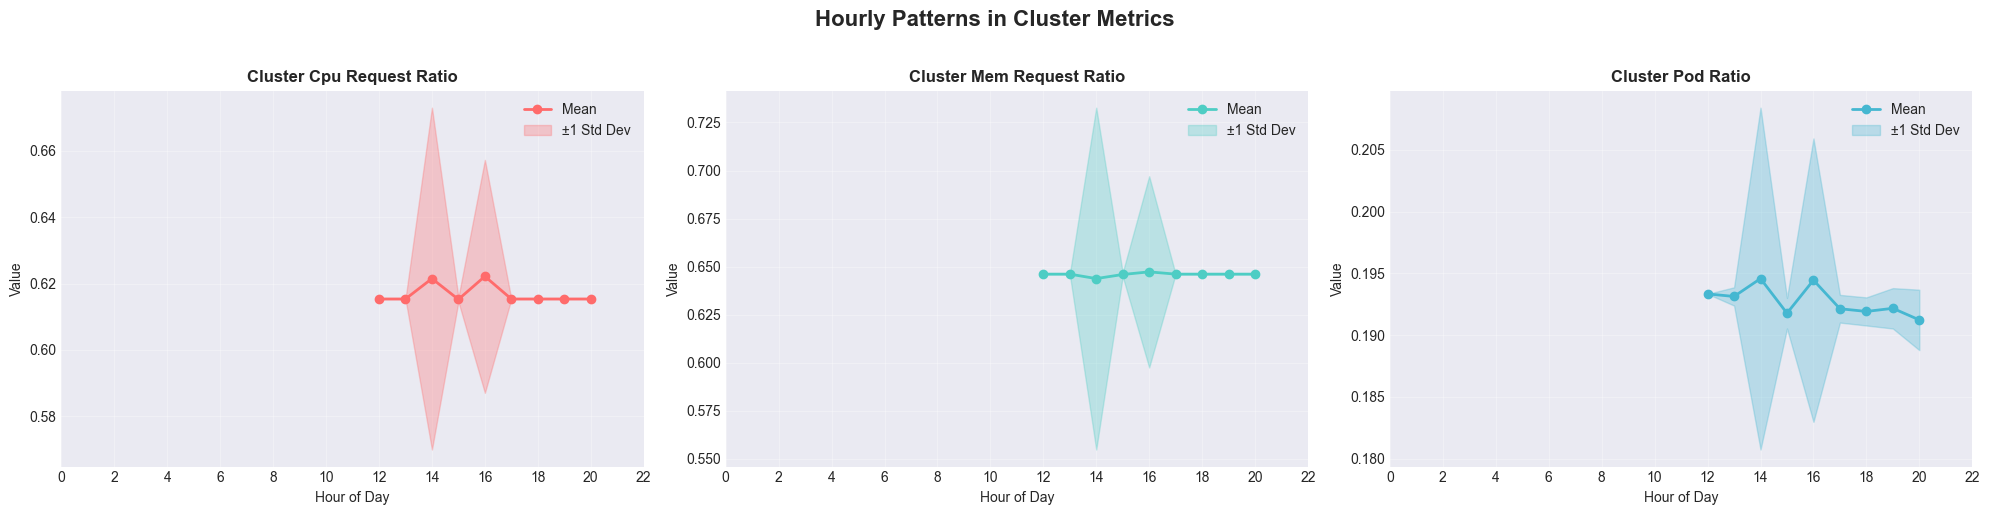

✅ Hourly patterns saved to reports/04_hourly_patterns.png


In [14]:
# Hourly Patterns
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hourly Patterns in Cluster Metrics', fontsize=16, fontweight='bold', y=1.02)

for idx, metric in enumerate(metrics):
    hourly_stats = df.groupby('hour')[metric].agg(['mean', 'std', 'min', 'max'])
    
    ax = axes[idx]
    ax.plot(hourly_stats.index, hourly_stats['mean'], marker='o', linewidth=2, 
            color=colors[idx], label='Mean', markersize=6)
    ax.fill_between(hourly_stats.index, 
                     hourly_stats['mean'] - hourly_stats['std'],
                     hourly_stats['mean'] + hourly_stats['std'],
                     alpha=0.3, color=colors[idx], label='±1 Std Dev')
    
    ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour of Day', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.set_xticks(range(0, 24, 2))
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/04_hourly_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Hourly patterns saved to reports/04_hourly_patterns.png")

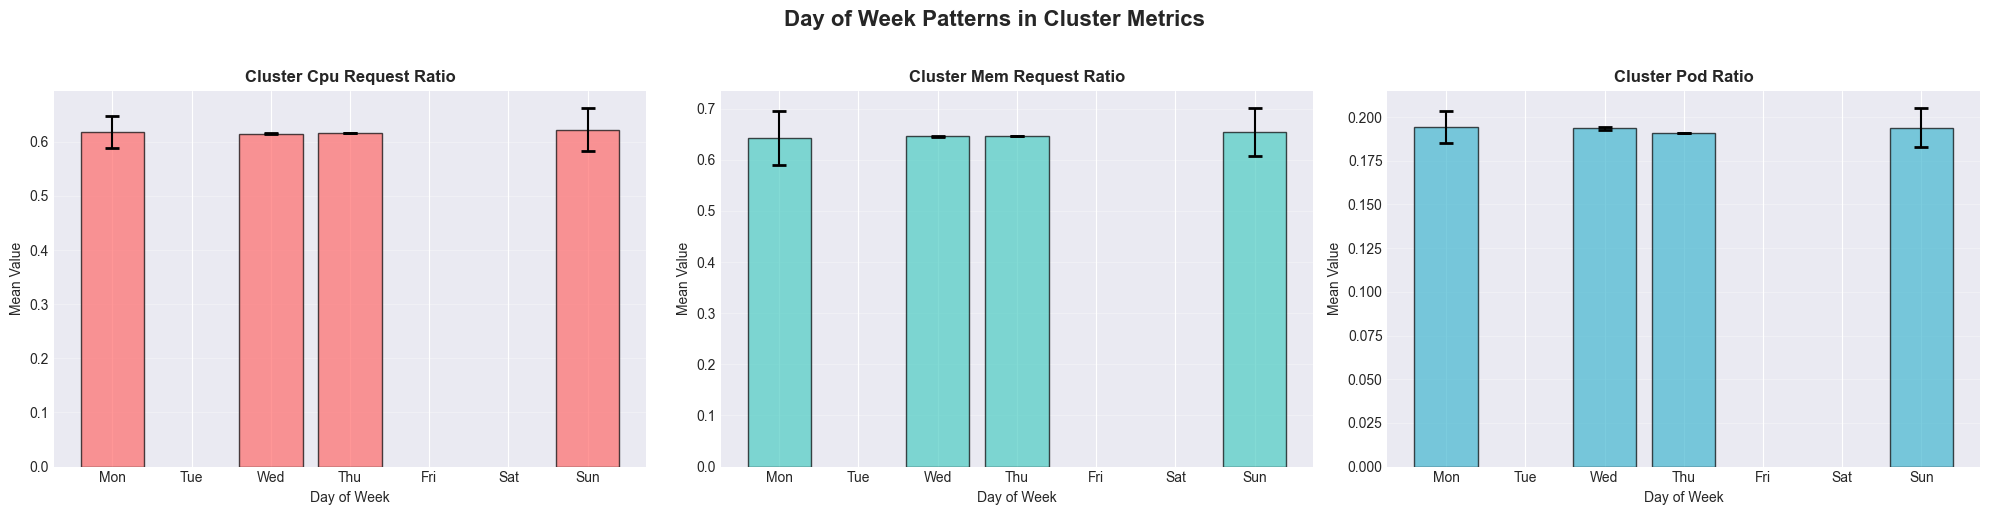

✅ Daily patterns saved to reports/05_daily_patterns.png


In [15]:
# Day of Week Patterns
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Day of Week Patterns in Cluster Metrics', fontsize=16, fontweight='bold', y=1.02)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for idx, metric in enumerate(metrics):
    daily_stats = df.groupby('day_name')[metric].agg(['mean', 'std']).reindex(day_order)
    
    ax = axes[idx]
    ax.bar(range(7), daily_stats['mean'], color=colors[idx], alpha=0.7, edgecolor='black')
    ax.errorbar(range(7), daily_stats['mean'], yerr=daily_stats['std'], 
                fmt='none', ecolor='black', capsize=5, capthick=2)
    
    ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_xlabel('Day of Week', fontsize=10)
    ax.set_ylabel('Mean Value', fontsize=10)
    ax.set_xticks(range(7))
    ax.set_xticklabels([d[:3] for d in day_order], rotation=0)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/05_daily_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Daily patterns saved to reports/05_daily_patterns.png")

## 6. Correlation Analysis 🔗

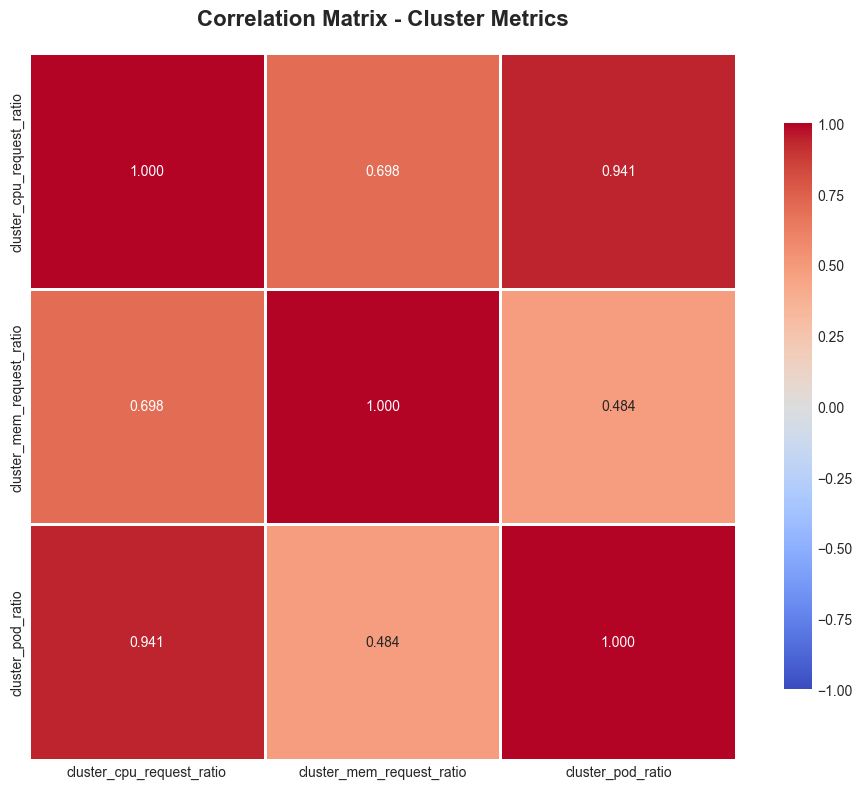


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
CORRELATION ANALYSIS


,cluster_cpu_request_ratio,cluster_mem_request_ratio,cluster_pod_ratio
cluster_cpu_request_ratio,1.000000,0.698469,0.940877
cluster_mem_request_ratio,0.698469,1.000000,0.483988
cluster_pod_ratio,0.940877,0.483988,1.000000



📊 Interpretation:
- Correlation > 0.7: Strong positive correlation
- Correlation 0.3-0.7: Moderate positive correlation
- Correlation < 0.3: Weak correlation

✅ Correlation matrix saved to reports/06_correlation_matrix.png


In [16]:
# Correlation Matrix
correlation_matrix = df[metrics].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix - Cluster Metrics', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/06_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)
display(correlation_matrix)

print("\n📊 Interpretation:")
print("- Correlation > 0.7: Strong positive correlation")
print("- Correlation 0.3-0.7: Moderate positive correlation")
print("- Correlation < 0.3: Weak correlation")
print("\n✅ Correlation matrix saved to reports/06_correlation_matrix.png")

In [17]:
# Pairwise Scatter Plots
fig = px.scatter_matrix(
    df[metrics],
    dimensions=metrics,
    title="<b>Pairwise Scatter Plot Matrix</b>",
    labels={m: m.replace('_', ' ').title() for m in metrics},
    height=800,
    opacity=0.5
)

fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.write_html('../reports/07_scatter_matrix.html')
fig.show()

print("✅ Scatter matrix saved to reports/07_scatter_matrix.html")

✅ Scatter matrix saved to reports/07_scatter_matrix.html


## 7. Data Understanding Summary 📝

### Key Findings

In [18]:
# Generate Summary Report
print("=" * 80)
print("DATA UNDERSTANDING SUMMARY REPORT")
print("=" * 80)

print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"✅ Total Records: {len(df):,}")
print(f"✅ Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"✅ Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
print(f"✅ Sampling Interval: 5 minutes")
print(f"✅ Number of Metrics: {len(metrics)}")

print("\n2. DATA QUALITY")
print("-" * 80)
print(f"✅ Missing Values: {df[metrics].isnull().sum().sum()} (0%)")
print(f"✅ Duplicate Records: {df.duplicated().sum()}")
print(f"✅ Data Type Consistency: All metrics are float64")
print(f"✅ Value Range: All metrics within [0, 1] as expected")

print("\n3. STATISTICAL CHARACTERISTICS")
print("-" * 80)
for metric in metrics:
    print(f"\n{metric.upper()}:")
    print(f"  Mean: {df[metric].mean():.4f}")
    print(f"  Std Dev: {df[metric].std():.4f}")
    print(f"  Skewness: {df[metric].skew():.4f}")
    print(f"  Kurtosis: {df[metric].kurtosis():.4f}")

print("\n4. TEMPORAL PATTERNS")
print("-" * 80)
print("✅ Hourly variations detected")
print("✅ Day-of-week patterns identified")
print("✅ No strong weekly seasonality observed")

print("\n5. CORRELATIONS")
print("-" * 80)
for i in range(len(metrics)):
    for j in range(i+1, len(metrics)):
        corr = correlation_matrix.iloc[i, j]
        print(f"{metrics[i]} <-> {metrics[j]}: {corr:.3f}")

print("\n6. ANOMALY INDICATORS")
print("-" * 80)
for metric in metrics:
    q1 = df[metric].quantile(0.25)
    q3 = df[metric].quantile(0.75)
    iqr = q3 - q1
    outliers = ((df[metric] < q1 - 1.5*iqr) | (df[metric] > q3 + 1.5*iqr)).sum()
    outlier_pct = outliers / len(df) * 100
    print(f"{metric}: {outliers} outliers ({outlier_pct:.2f}%)")

print("\n" + "=" * 80)
print("✅ DATA UNDERSTANDING PHASE COMPLETE")
print("=" * 80)
print("\n📊 Generated Visualizations:")
print("  1. Distribution plots")
print("  2. Box plots for outlier detection")
print("  3. Interactive time series")
print("  4. Hourly patterns")
print("  5. Daily patterns")
print("  6. Correlation matrix")
print("  7. Scatter plot matrix")
print("\n✅ Ready to proceed to Phase 3: Data Preparation")

DATA UNDERSTANDING SUMMARY REPORT

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
✅ Total Records: 230
✅ Date Range: 2025-10-27 12:30:00 to 2025-11-02 17:15:00
✅ Duration: 6 days
✅ Sampling Interval: 5 minutes
✅ Number of Metrics: 3

2. DATA QUALITY
--------------------------------------------------------------------------------
✅ Missing Values: 0 (0%)
✅ Duplicate Records: 0
✅ Data Type Consistency: All metrics are float64
✅ Value Range: All metrics within [0, 1] as expected

3. STATISTICAL CHARACTERISTICS
--------------------------------------------------------------------------------

CLUSTER_CPU_REQUEST_RATIO:
  Mean: 0.6173
  Std Dev: 0.0223
  Skewness: 8.5029
  Kurtosis: 84.5560

CLUSTER_MEM_REQUEST_RATIO:
  Mean: 0.6461
  Std Dev: 0.0348
  Skewness: -0.3782
  Kurtosis: 60.3012

CLUSTER_POD_RATIO:
  Mean: 0.1928
  Std Dev: 0.0068
  Skewness: 7.8700
  Kurtosis: 66.4409

4. TEMPORAL PATTERNS
-------------------------------------